In [51]:
from dotenv import load_dotenv
import os

load_dotenv()
# get keys for your project from https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = os.getenv("LANGFUSE_PUBLIC_KEY")
os.environ["LANGFUSE_SECRET_KEY"] = os.getenv("LANGFUSE_SECRET_KEY")
 
# your openai key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
 
# Your host, defaults to https://cloud.langfuse.com
# For US data region, set to "https://us.cloud.langfuse.com"
# os.environ["LANGFUSE_HOST"] = "http://localhost:3000"


In [52]:
import fitz  # PyMuPDF
from langdetect import detect
import re

def clean_text(text):
    # Replace multiple whitespace with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Remove leading and trailing whitespace
    text = text.strip()
    
    return text

def extract_and_clean_english_text(pdf_path, max_page=66):
    """
    Extracts and cleans English text from a PDF up to a specified page.
    
    Args:
    pdf_path (str): The path to the PDF file.
    max_page (int): The maximum number of pages to process.

    Returns:
    str: The cleaned and concatenated English text extracted from the PDF.
    """
    # Open the PDF file
    pdf_document = fitz.open(pdf_path)

    # Initialize a list to hold all English text
    english_text = []

    # Loop through each page in the PDF until the specified max_page
    for page_num in range(min(len(pdf_document), max_page)):
        page = pdf_document.load_page(page_num)
        
        # Extract text from the page
        text = page.get_text("text")
        
        # Split text into sentences/lines
        lines = re.split(r'\n', text)
        
        # Detect language and filter for English
        for line in lines:
            try:
                if detect(line) == 'en':
                    cleaned_line = clean_text(line)
                    if cleaned_line:  # Add only non-empty cleaned lines
                        english_text.append(cleaned_line)
            except:
                continue  # Skip lines where language detection fails

    return " ".join(english_text)

# Use the function
pdf_path = "washer.pdf"
english_text = extract_and_clean_english_text(pdf_path)
print(english_text)

Untitled-5 1 English Safety information What you need to know about the safety instructions Important safety symbols Critical installation warnings Critical usage warnings Critical cleaning warnings Installation Whats included Step-by-step installation Before you start Initial settings Operations Simple steps to start Cycle overview Emergency drain Cleaning Recovery from freezing Care against an extended time of disuse Untitled-5 2 English 3 Troubleshooting Checkpoints Information codes Specifications Protecting the environment Specification sheet Information of main washing cycles Untitled-5 3 English Safety information Congratulations on your new Samsung washing machine. This manual contains important information on the installation, use and care of your appliance. Please take some time to read this manual to take full advantage of your washing machines many benefits and features. What you need to know about the safety instructions Please read this manual thoroughly to ensure that yo

In [53]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma 
from langchain_openai import OpenAIEmbeddings



# Set embeddings
embd = OpenAIEmbeddings()

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=500
)

def split_text_into_chunks(text, chunk_size=2000, chunk_overlap=350):
    # Initialize the text splitter
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    
    # Split the text into chunks
    text_chunks = text_splitter.split_text(text)
    return text_chunks

# Use the functions
pdf_path = "washer.pdf"
cleaned_english_text = extract_and_clean_english_text(pdf_path)
text_chunks = split_text_into_chunks(cleaned_english_text)






# Add to vectorstore
vectorstore = Chroma.from_texts(
  texts=text_chunks,
  collection_name="rag-chroma",
  embedding=embd
)

retriever = vectorstore.as_retriever()

In [54]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)


from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives 
    | ChatOpenAI(temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)


In [55]:
# Define the original question
question = "What is the level feet of the machine"

# Use the generate_queries chain
alternative_queries = generate_queries.invoke({"question": question})

print(alternative_queries)


["1. Can you provide information on the machine's height in feet?", '2. How tall is the machine in terms of feet?', "3. What is the machine's vertical measurement in feet?", "4. Could you tell me the machine's elevation in feet?", "5. What is the machine's height expressed in feet?"]


In [56]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "what are the componments of the washer machine?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union

docs = retrieval_chain.invoke({"question":question})
len(docs)

9

In [57]:
print(type(retrieval_chain))  # Should be a LangChain Chain or RunnableSequence

print(type(docs))  # Should be a list of documents


<class 'langchain_core.runnables.base.RunnableSequence'>
<class 'list'>


In [ ]:
! pip install langfuse

In [59]:
from langfuse.callback import CallbackHandler
langfuse_handler=CallbackHandler()

In [115]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter
import json
# Define the prompt template
prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful assistant, Answer the question based only on the following context :{context}"
            "Answer the question based on the above question: {question}"
            "Provide a detailed answer."
            "Don't justify your answers."
            "Don't give information not mentioned in the CONTEXT INFORMATION."
            "Do not say ""according to the context" "or ""mentioned in the context" "or similar."
            "if you don't know the answer, don't halucinate.Just say:'I can't answer this question  since it is not mentioned in the context."),
    """),
    ("human", "{question}"),
])

# Initialize the language model
llm = ChatOpenAI(temperature=0)

# Define the chain
final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

# Define your question and retrieval chain
question = "What should you do to ensure you know how to safely and efficiently operate your new appliance?"

# Invoke the chain
response = final_rag_chain.invoke({"question": question}, config={"callbacks": [langfuse_handler]})
print(response)



Read the manual thoroughly to ensure you know how to safely and efficiently operate the appliance. Store the manual in a safe location close to the appliance for future reference. Use the appliance only for its intended purpose as described in the instruction manual. Familiarize yourself with the operation of the appliance and exercise care when using it.


In [61]:
from langfuse import Langfuse
langfuse = Langfuse()
 
trace = langfuse.trace(
    tags=["my_questions"]
)

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter
import json
# Define the prompt template
prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful assistant, Answer the question based only on the following context :{context}"
            "Answer the question based on the above question: {question}"
            "Provide a detailed answer."
            "Don't justify your answers."
            "Don't give information not mentioned in the CONTEXT INFORMATION."
            "Do not say ""according to the context" "or ""mentioned in the context" "or similar."
            "if you don't know the answer, don't halucinate.Just say:'I can't answer this question  since it is not mentioned in the context."),
    """),
    ("human", "{question}"),
])

# Initialize the language model
llm = ChatOpenAI(temperature=0)

# Define the chain
final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

questions=[]

def generate_answers(questions):
    answers = []
    for question in questions:    
        response = final_rag_chain.invoke({"question": question}, config={"callbacks": [langfuse_handler]})
    answers.append(response)
    return answers

# Define a list of questions and get the answers
questions = ["What should you do to ensure you know how to safely and efficiently operate your new appliance?",
        "Where should you store the manual for future reference?",
        "For what purpose should you use the appliance according to the manual?",
        "Do the Warnings and Important Safety Instructions cover all possible conditions and situations?",
        "What is your responsibility when installing, maintaining, and operating the washing machine?",
        "Why might the characteristics of your washing machine differ slightly from those described in the manual?",
        "What should you do if you have any questions or concerns?",
        "What does the WARNING symbol indicate in the user manual?",
        "What does the CAUTION symbol mean in the user manual?",
        "What does the NOTE symbol signify in the user manual?",
        "What should we do if the supply cord is damaged?",
        "How to reduce the risk of fire, electric shock, or injury to persons when using your appliance?",
        "What is the age requirement for children to use the appliance in Europe?",
        "What should be done if the supply cord is damaged?",
        "What is the recommendation regarding the hose-sets supplied with the appliance?",
        "What is the cautionary advice given for appliances with children in Europe?",
        "Who must perform the installation of the appliance?",
        "What may result from failure to follow installation warnings?",
        "What should you do to avoid electrical hazards when lifting the appliance?",
        "Why should you plug the power plug into the wall socket so the cord is running towards the floor?",
        "What precautions should you take with regard to packaging materials?",
        "What should you do if the appliance is damaged or you suspect damage?",
        "Why is it important to install the appliance properly?",
        "What should you avoid doing to prevent electric shock or fire when unplugging the power cord?",
        "What should be avoided when positioning the appliance to prevent it from causing harm or damage?",
        "Why is it important to avoid twisting or damaging the power cord?",
        "What should you do if the appliance power plug or power cord is damaged?",
        "What should you do with the power cord when positioning heavy objects?",
        "What are the dangers of installing the appliance in certain locations such as near water or in a dusty location?",
        "What should you do if the washing machine is contaminated by a foreign substance?",
        "What are the consequences of not cleaning the washing machine when contaminated by foreign substances?",
        "What precautions should be taken when using the front glass of the washing machine?",
        "How should you handle the water supply hose to prevent damage?",
        "What should you check if a draining error occurs during operation?",
        "What could happen if laundry gets caught in the door of the washing machine?",
        "When should you turn off the water supply valve?",
        "How can you ensure that there is no water leak before using the washing machine?",
        "What should you not do with the appliance to prevent damage?",
        "What should you avoid spraying onto the washing machine?",
        "What should you avoid placing near the washing machine?",
        "What should you not do during a high-temperature wash or drying cycle?",
        "What should you avoid washing in the washing machine?",
        "How should you insert the laundry into the washing machine?",
        "What should you ensure about the screws on the water supply hose connector?",
        "What is the intended use of the washing machine?",
        "What happens if you use the washing machine for business purposes?",
        "What are the components of the washing machine?",
        "What electrical supply and grounding requirements are necessary for the washing machine?",
        "What should be done if the provided power plug does not fit the outlet?",
        "What are the warnings associated with electrical supply and grounding?",
        "What should the water pressure be for the washing machine?",
        "What could happen if the water pressure is lower than 50 kPa?",
        "How should the water taps be positioned relative to the washing machine?",
        "What should be done to reduce the risk of water leaks?",
        "What should be done before using the washing machine for the first time?",
        "How far should the water taps be from the rear of the washing machine?",
        "What does Samsung recommend for drainage?",
        "Where should you not install the washing machine?",
        "What kind of flooring is best for the washing machine?",
        "What are the minimum clearance requirements for stable operation of the washing machine?",
        "What should you ensure if the washing machine and dryer are installed in the same location?",
        "What are the step by step installations?",
        "For selecting a location, what are the location requirements?",
        "How to adjust the leveling feet?",
        "What is the first step in connecting the water hose?",
        "How can you ensure the water hose is securely connected to the adapter?",
        "What tool is suggested to loosen the adapter if it is too tight?",
        "What is the second step after connecting the water hose to the adapter?",
        "How should you insert the adapter into the water tap?",
        "What should you do while holding down part (B) during the installation?",
        "What additional step should you take if using a screw-type water tap?",
        "Where should the other end of the water hose be connected?",
        "What should you do after connecting the water hose to the inlet valve?",
        "What precaution should be taken if there are leaks in the connection?",
        "What are the three ways to position the drain hose?",
        "At what height should the drain hose be placed over the edge of a wash basin?",
        "How can you secure the drain hose when positioning it over the edge of a wash basin?",
        "What is the requirement for the height of the drain pipe when inserted directly into it?",
        "What are the diameter and capacity requirements for the drain pipe?",
        "What is the caution mentioned regarding the positioning of the drain hose?",
        "What should you avoid when positioning the drain hose?",
        "What is the final step before turning on the washing machine?",
        "What is the recommended height range for positioning the drain hose in any method?",
        "Why is calibration recommended for the washing machine?",
        "What should be done before running the calibration cycle?",
        "What is the first step to enter Calibration mode?",
        "Which buttons need to be held down to enter Calibration mode?",
        "What message appears when Calibration mode is activated?",
        "How do you start the Calibration cycle?",
        "How long does the drum rotate during the Calibration cycle?",
        "What happens when the Calibration cycle is complete?",
        "What does the washing machine display when the Calibration cycle is complete?",
        "What is the final step once the Calibration cycle is complete?",
        "What is the function of the cycle selector on the control panel?",
        "What options can you adjust using the Temp button?",
        "What does the Rinse button do?",
        "How can you adjust the spin speed using the control panel?",
        "What does the Soil button allow you to do?",
        "What is indicated by the PM options on the control panel?",
        "What does the Delay End button do?",
        "What is the purpose of the Start/Pause button?",
        "What does the Power button do?",
        "What happens when you press the Easy Iron button?",
        "What must we do if the washing machine does not start?",
        "What to do if the water supply is insufficient or no water is supplied?"

]

responses = generate_answers(questions)
# Print the responses
for i, response in enumerate(responses):
    print(f"Question: {questions[i]}")
    print(f"Answer: {response}\n")

In [ ]:
! pip install matplotlib

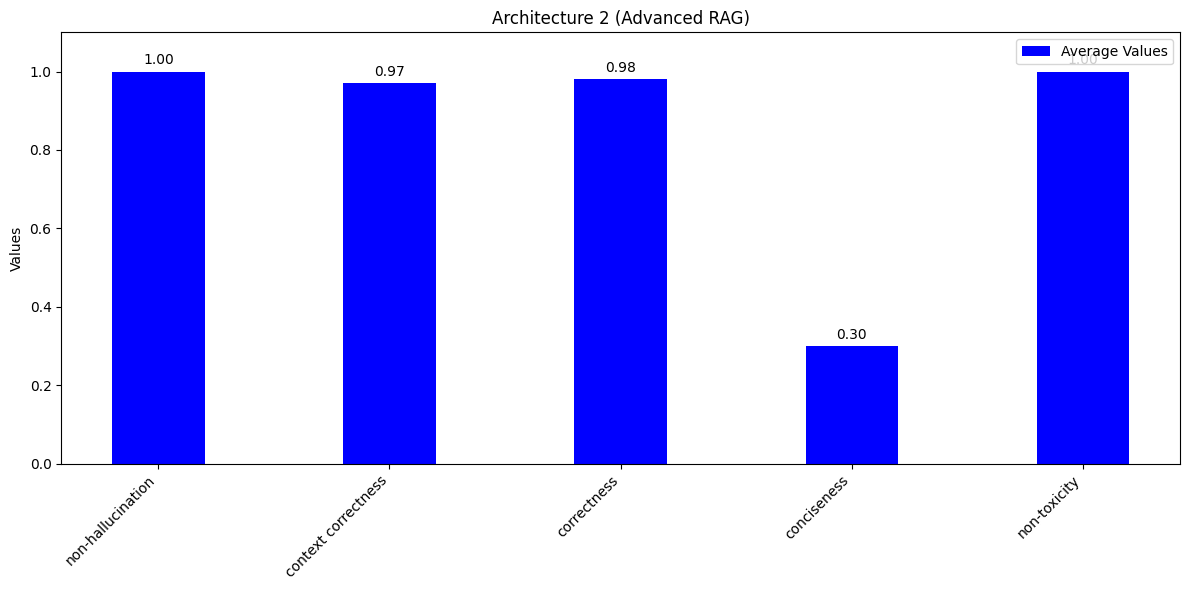

In [159]:
import matplotlib.pyplot as plt
import numpy as np

# Data points
metrics = [
    "non-hallucination", "context correctness", "correctness", "conciseness", "non-toxicity"
]
average_value = [1, 0.97, 0.98, 0.3, 1]  # Added one more value to match the number of metrics

# Plot settings
x = np.arange(len(metrics))
width = 0.4

fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted figure size for better clarity

# Create bar chart with blue color
bars = ax.bar(x, average_value, width, label="Average Values", color='blue')

# Labels, title, and custom x-axis tick labels
ax.set_ylabel("Values")
ax.set_title("Architecture 2 (Advanced RAG)")
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')  # Rotate labels for better fit
ax.set_ylim(0, 1.1)
ax.legend()

# Add value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.2f}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

add_labels(bars)

plt.tight_layout()  # Adjust layout to fit labels better
plt.show()


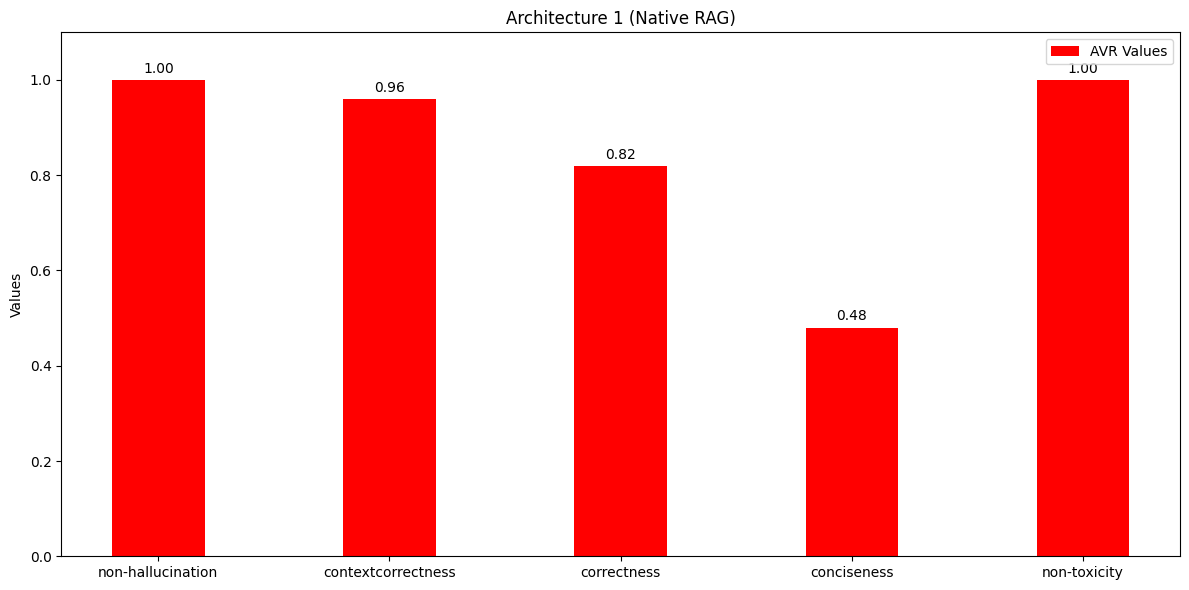

In [156]:
import matplotlib.pyplot as plt
import numpy as np

# Data points
metrics = [
    "non-hallucination", "contextcorrectness", "correctness", "conciseness", "non-toxicity", 
]
avrage_value = [1, 0.96, 0.82, 0.48, 1]

# Plot settings
x = np.arange(len(metrics))
width = 0.4

fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted figure size for better clarity

# Create bar chart for average values only with red color
bars = ax.bar(x, avrage_value, width, label="AVR Values", color='red')  # Red color

# Labels, title, and custom x-axis tick labels
ax.set_ylabel("Values")
ax.set_title("Architecture 1 (Native RAG)")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()

# Add value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.2f}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

add_labels(bars)

plt.tight_layout()  # Adjust layout to fit labels better
plt.show()

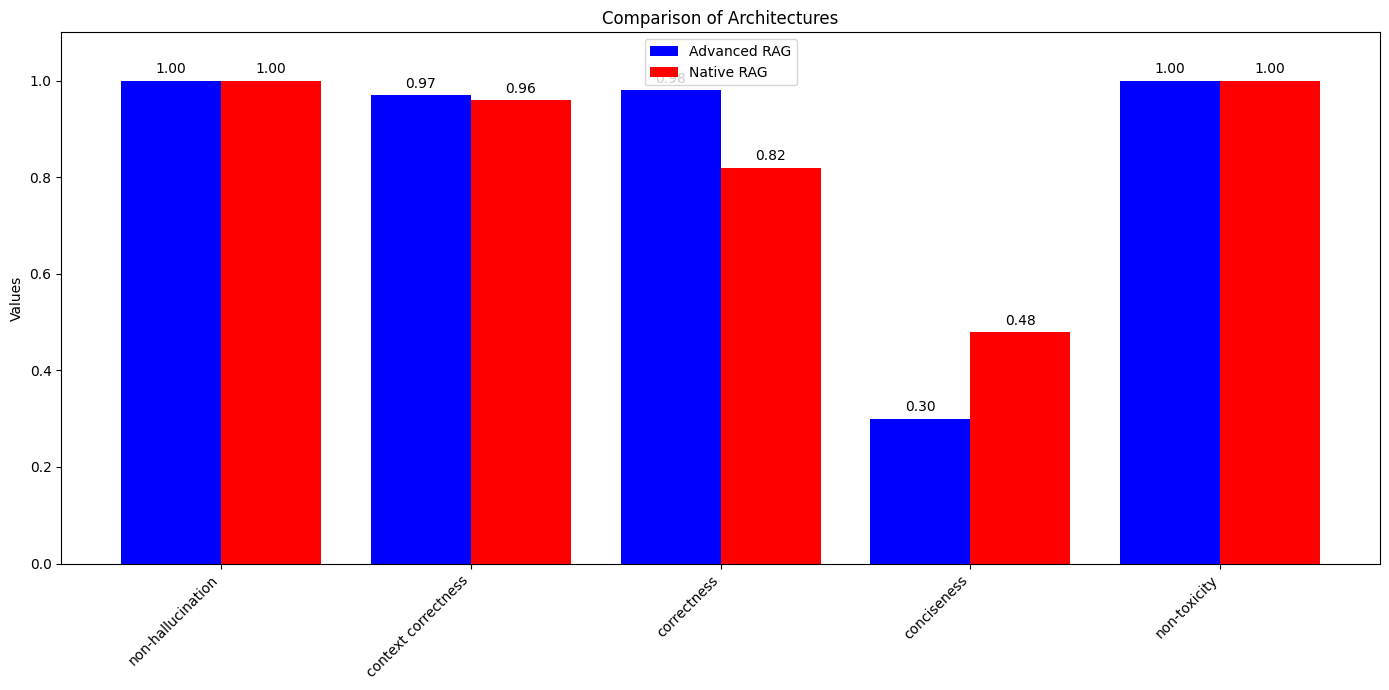

In [160]:
import matplotlib.pyplot as plt
import numpy as np

# Data points for both architectures
metrics = [
    "non-hallucination", "context correctness", "correctness", "conciseness", "non-toxicity"
]

average_value_1 = [1, 0.97, 0.98, 0.3, 1]  # Data for Architecture 2 (Advanced RAG)
average_value_2 = [1, 0.96, 0.82, 0.48, 1]  # Data for Architecture 1 (Native RAG)

# Plot settings
x = np.arange(len(metrics))  # Position of bars on x-axis
width = 0.4  # Width of the bars

fig, ax = plt.subplots(figsize=(14, 7))  # Adjusted figure size for better clarity

# Create bar charts for both datasets
bars_1 = ax.bar(x - width/2, average_value_1, width, label="Advanced RAG", color='blue')  # Blue color
bars_2 = ax.bar(x + width/2, average_value_2, width, label="Native RAG", color='red')  # Red color

# Labels, title, and custom x-axis tick labels
ax.set_ylabel("Values")
ax.set_title("Comparison of Architectures")
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')  # Rotate labels for better fit
ax.set_ylim(0, 1.1)
ax.legend()

# Add value labels for both bar sets
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.2f}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

add_labels(bars_1)
add_labels(bars_2)

plt.tight_layout()  # Adjust layout to fit labels better
plt.show()


In [150]:
import numpy as np

# Define the metrics and their values
metrics = {
    "conciseness-v1": {"avg": 0.3, "min": 0, "max": 1},
    "contextcorrectness-v1": {"avg": 0.97, "min": 0.95, "max": 1},
    "correctness-v1": {"avg": 0.98, "min": 0, "max": 1},
    "absence of hallucination": {"avg": 1, "min": 1, "max": 1},
    "absence of toxicity": {"avg": 1, "min": 1, "max": 1}
}

# Define the weights
weights = {
    "conciseness-v1":0.1,
    "contextcorrectness-v1": 0.1,
    "absence of hallucination": 0.1,
    "correctness-v1": 0.6,
    "absence of toxicity": 0.1 

}

# Calculate the accuracy metric
def calculate_accuracy(metric_values, weights):
    avg_accuracy = sum(weights[m] * metric_values[m]["avg"] for m in weights)
    min_accuracy = sum(weights[m] * metric_values[m]["min"] for m in weights)
    max_accuracy = sum(weights[m] * metric_values[m]["max"] for m in weights)
    return avg_accuracy, min_accuracy, max_accuracy

# Compute accuracy values
avg_accuracy, min_accuracy, max_accuracy = calculate_accuracy(metrics, weights)

print(f"Accuracy Metric - Avg: {avg_accuracy:.2f}, Min: {min_accuracy:.2f}, Max: {max_accuracy:.2f}")


Accuracy Metric - Avg: 0.91, Min: 0.30, Max: 1.00


In [152]:
import numpy as np

# Define the metrics and their values
metrics = {
    "conciseness-v1": {"avg": 0.48, "min": 0, "max": 1},
    "contextcorrectness-v1": {"avg": 0.96, "min": 0, "max": 1},
    "correctness-v1": {"avg": 0.82, "min": 0, "max": 1},
    "absence of hallucination": {"avg": 1, "min": 1, "max": 1},
    "absence of toxicity": {"avg": 1, "min": 1, "max": 1}
}

# Define the weights
weights = {
    "conciseness-v1":0.1,
    "contextcorrectness-v1": 0.1,
    "absence of hallucination": 0.1,
    "correctness-v1": 0.6,
    "absence of toxicity": 0.1

}

# Calculate the accuracy metric
def calculate_accuracy(metric_values, weights):
    avg_accuracy = sum(weights[m] * metric_values[m]["avg"] for m in weights)
    min_accuracy = sum(weights[m] * metric_values[m]["min"] for m in weights)
    max_accuracy = sum(weights[m] * metric_values[m]["max"] for m in weights)
    return avg_accuracy, min_accuracy, max_accuracy

# Compute accuracy values
avg_accuracy, min_accuracy, max_accuracy = calculate_accuracy(metrics, weights)

print(f"Accuracy Metric - Avg: {avg_accuracy:.2f}, Min: {min_accuracy:.2f}, Max: {max_accuracy:.2f}")


Accuracy Metric - Avg: 0.84, Min: 0.20, Max: 1.00


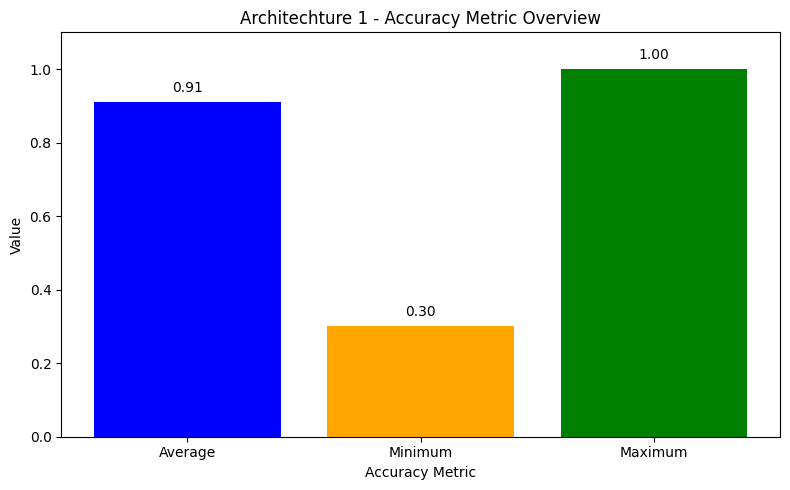

In [164]:
import matplotlib.pyplot as plt

# Define the accuracy metric values
metrics = ['Average', 'Minimum', 'Maximum']
values = [0.91, 0.30, 1.00]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'orange', 'green'])

# Add labels and title
plt.xlabel('Accuracy Metric')
plt.ylabel('Value')
plt.title('Architechture 1 - Accuracy Metric Overview')
plt.ylim(0, 1.1)  # Set y-axis limits for better visualization

# Add value labels on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


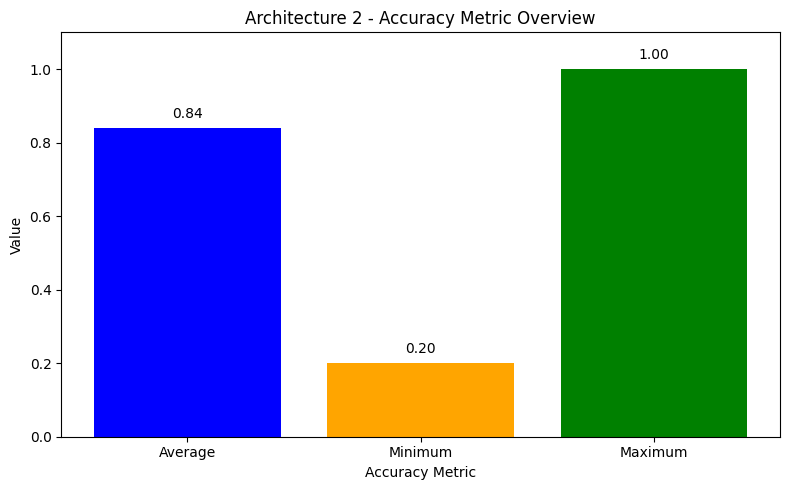

In [163]:
import matplotlib.pyplot as plt

# Define the accuracy metric values
metrics = ['Average', 'Minimum', 'Maximum']
values = [0.84, 0.20, 1.00]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'orange', 'green'])

# Add labels and title
plt.xlabel('Accuracy Metric')
plt.ylabel('Value')
plt.title('Architecture 2 - Accuracy Metric Overview')
plt.ylim(0, 1.1)  # Set y-axis limits for better visualization

# Add value labels on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


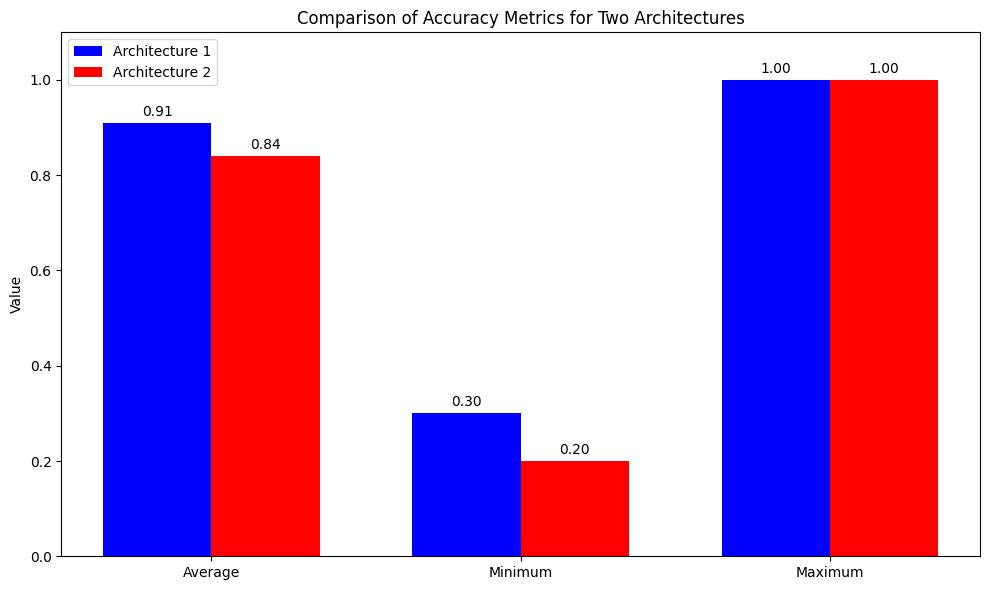

In [167]:
import matplotlib.pyplot as plt
import numpy as np

# Define the accuracy metric values for both architectures
metrics = ['Average', 'Minimum', 'Maximum']
values_arch1 = [0.91, 0.30, 1.00]  # Architecture 1
values_arch2 = [0.84, 0.20, 1.00]  # Architecture 2

# Plot settings
x = np.arange(len(metrics))  # Position of bars on x-axis
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted figure size for better clarity

# Create bar charts for both datasets
bars_arch1 = ax.bar(x - width/2, values_arch1, width, label='Architecture 1', color='blue')
bars_arch2 = ax.bar(x + width/2, values_arch2, width, label='Architecture 2', color='red')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Value')
ax.set_title('Comparison of Accuracy Metrics for Two Architectures')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)  # Set y-axis limits for better visualization
ax.legend()

# Add value labels on top of the bars for both datasets
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.2f}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

add_labels(bars_arch1)
add_labels(bars_arch2)

plt.tight_layout()  # Adjust layout to fit labels better
plt.show()


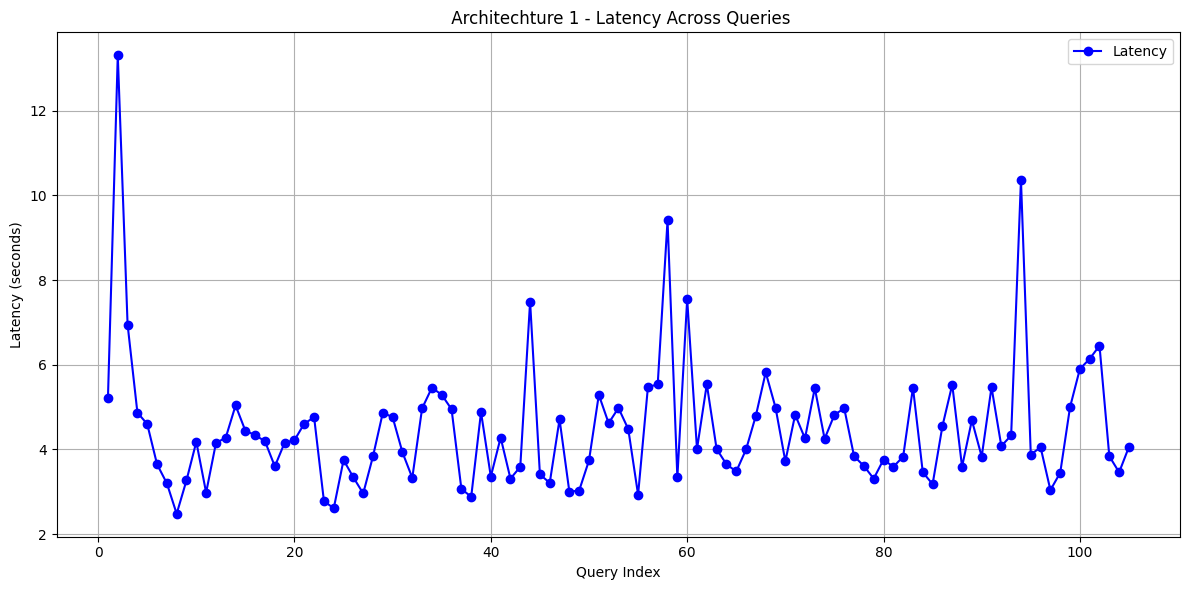

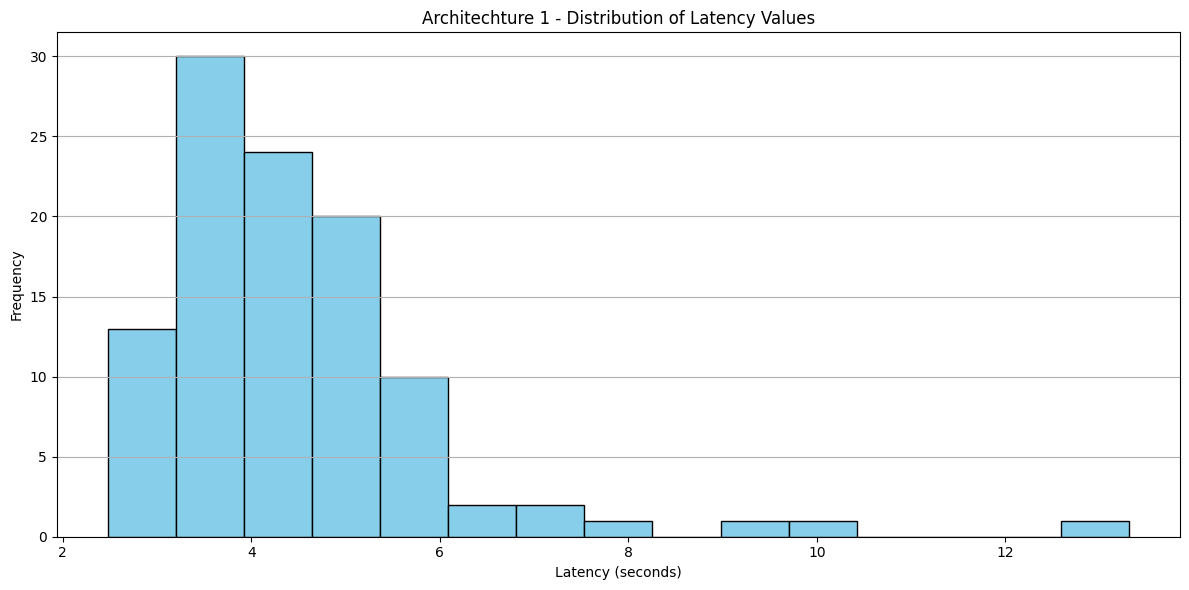

In [175]:
import matplotlib.pyplot as plt

# List of latency values as strings
latency_values = [
    "5.22s", "13.31s", "6.95s", "4.87s", "4.60s", "3.65s", "3.20s", "2.48s", 
    "3.27s", "4.18s", "2.98s", "4.15s", "4.28s", "5.04s", "4.44s", "4.34s", 
    "4.19s", "3.60s", "4.16s", "4.22s", "4.61s", "4.76s", "2.78s", "2.61s", 
    "3.75s", "3.34s", "2.96s", "3.84s", "4.87s", "4.76s", "3.93s", "3.33s", 
    "4.97s", "5.46s", "5.29s", "4.95s", "3.07s", "2.88s", "4.88s", "3.36s", 
    "4.28s", "3.31s", "3.59s", "7.49s", "3.41s", "3.21s", "4.71s", "3.00s", 
    "3.03s", "3.74s", "5.29s", "4.62s", "4.98s", "4.48s", "2.93s", "5.47s", 
    "5.54s", "9.41s", "3.34s", "7.55s", "4.01s", "5.54s", "4.01s", "3.65s", 
    "3.48s", "4.00s", "4.80s", "5.82s", "4.99s", "3.72s", "4.82s", "4.26s", 
    "5.45s", "4.25s", "4.82s", "4.97s", "3.84s", "3.61s", "3.31s", "3.76s", 
    "3.59s", "3.83s", "5.46s", "3.46s", "3.18s", "4.55s", "5.53s", "3.59s", 
    "4.69s", "3.83s", "5.47s", "4.08s", "4.33s", "10.37s", "3.88s", "4.05s", 
    "3.04s", "3.45s", "5.00s", "5.90s", "6.14s", "6.45s", "3.84s", "3.46s", 
    "4.06s"
]

# Convert the latency values to floats
latency_floats = [float(value.strip('s')) for value in latency_values]

# Define x-axis values starting at 1
x_values = range(1, len(latency_floats) + 1)

# Create a line plot of the latency values
plt.figure(figsize=(12, 6))
plt.plot(x_values, latency_floats, marker='o', linestyle='-', color='b', label='Latency')
plt.title(' Architechture 1 - Latency Across Queries')
plt.xlabel('Query Index')
plt.ylabel('Latency (seconds)')
plt.grid(True)
plt.legend()

# Show the line plot
plt.tight_layout()
plt.show()

# Create a histogram of the latency values
plt.figure(figsize=(12, 6))
plt.hist(latency_floats, bins=15, color='skyblue', edgecolor='black')
plt.title('Architechture 1 - Distribution of Latency Values')
plt.xlabel('Latency (seconds)')
plt.ylabel('Frequency')
plt.grid(axis='y')

# Show the histogram
plt.tight_layout()
plt.show()


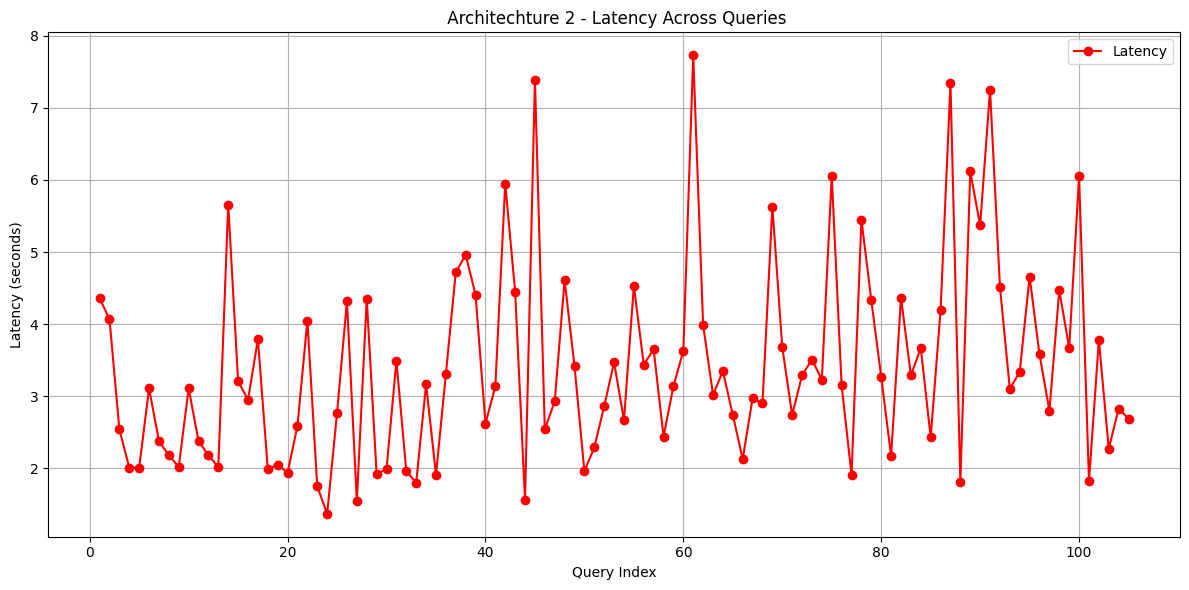

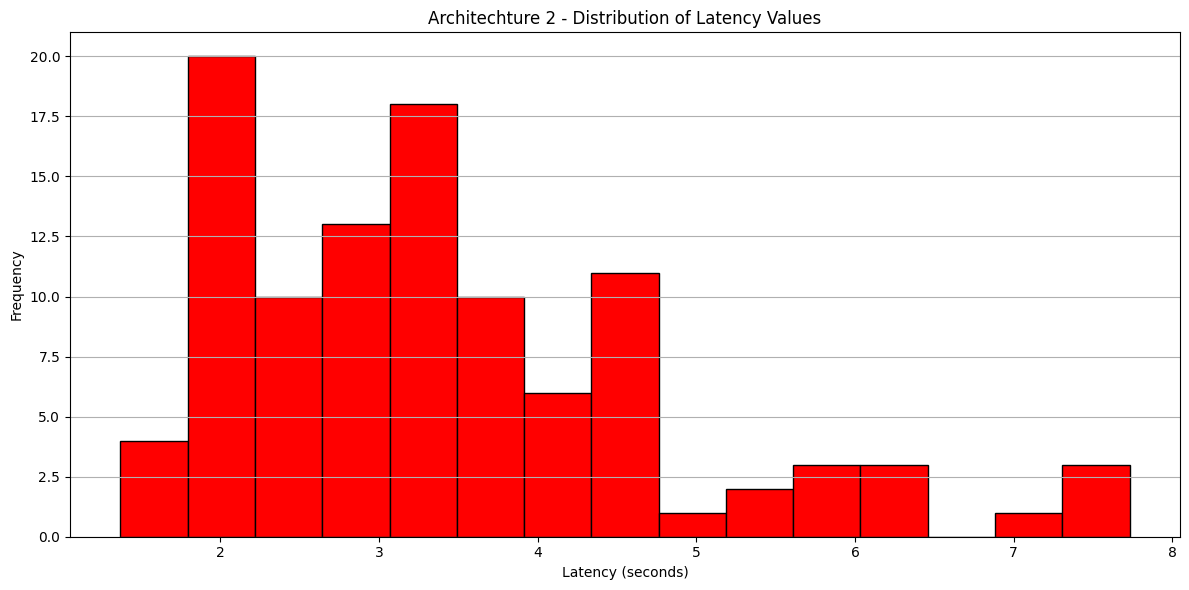

In [176]:
import matplotlib.pyplot as plt

# List of latency values as strings
latency_values  = [
  "4.36", "4.07","2.54", "2.01", "2.01", "3.11", "2.38", "2.18", "2.02", "3.11", "2.38", "2.18", "2.02", "5.66", "3.21", "2.95", "3.79", "1.99", "2.05", "1.94", "2.59", "4.05", "1.75", "1.37", "2.77", "4.32", "1.55", "4.35","1.92", "1.99","3.49", "1.96", "1.80", "3.17", "1.91", "3.31", "4.72", "4.96", "4.41", "2.62", "3.14", "5.95", "4.45","1.56", "7.39", "2.54", "2.93", "4.61", "3.42","1.96", "2.29","2.86","3.47","2.67","4.53", "3.44", "3.65", "2.44", "3.14","3.63","7.73","3.99","3.02","3.35","2.74","2.13","2.97", "2.90","5.63","3.68","2.74","3.29","3.51","3.23","6.06","3.15","1.91","5.45","4.33","3.27","2.17","4.37","3.29","3.67","2.43","4.19","7.34","1.81","6.12","5.37","7.25","4.52","3.10","3.34","4.66","3.58","2.80","4.47","3.67","6.05","1.82","3.78","2.27","2.83","2.69"    
]

# Convert the latency values to floats
latency_floats = [float(value.strip('s')) for value in latency_values]

# Define x-axis values starting at 1
x_values = range(1, len(latency_floats) + 1)

# Create a line plot of the latency values
plt.figure(figsize=(12, 6))
plt.plot(x_values, latency_floats, marker='o', linestyle='-', color='r', label='Latency')
plt.title(' Architechture 2 - Latency Across Queries')
plt.xlabel('Query Index')
plt.ylabel('Latency (seconds)')
plt.grid(True)
plt.legend()

# Show the line plot
plt.tight_layout()
plt.show()

# Create a histogram of the latency values
plt.figure(figsize=(12, 6))
plt.hist(latency_floats, bins=15, color='red', edgecolor='black')
plt.title('Architechture 2 - Distribution of Latency Values')
plt.xlabel('Latency (seconds)')
plt.ylabel('Frequency')
plt.grid(axis='y')

# Show the histogram
plt.tight_layout()
plt.show()


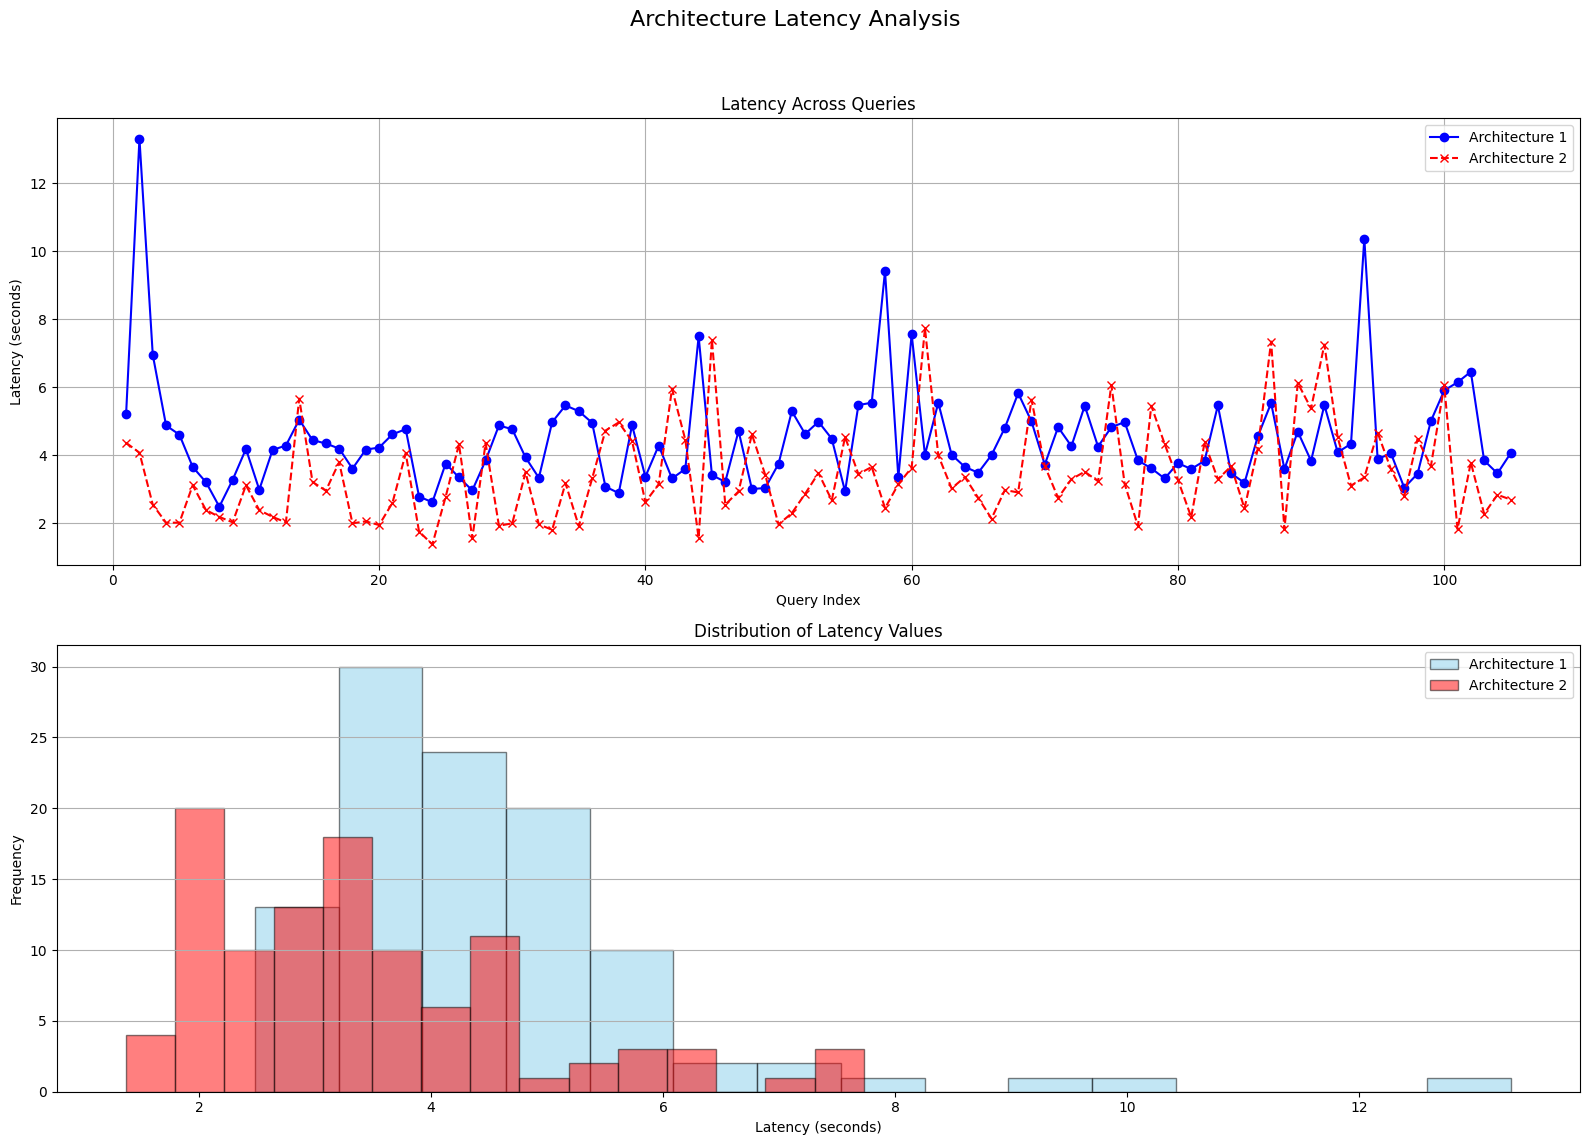

In [179]:
import matplotlib.pyplot as plt

# Define latency values for both architectures
latency_values_arch1 = [
    "5.22s", "13.31s", "6.95s", "4.87s", "4.60s", "3.65s", "3.20s", "2.48s", 
    "3.27s", "4.18s", "2.98s", "4.15s", "4.28s", "5.04s", "4.44s", "4.34s", 
    "4.19s", "3.60s", "4.16s", "4.22s", "4.61s", "4.76s", "2.78s", "2.61s", 
    "3.75s", "3.34s", "2.96s", "3.84s", "4.87s", "4.76s", "3.93s", "3.33s", 
    "4.97s", "5.46s", "5.29s", "4.95s", "3.07s", "2.88s", "4.88s", "3.36s", 
    "4.28s", "3.31s", "3.59s", "7.49s", "3.41s", "3.21s", "4.71s", "3.00s", 
    "3.03s", "3.74s", "5.29s", "4.62s", "4.98s", "4.48s", "2.93s", "5.47s", 
    "5.54s", "9.41s", "3.34s", "7.55s", "4.01s", "5.54s", "4.01s", "3.65s", 
    "3.48s", "4.00s", "4.80s", "5.82s", "4.99s", "3.72s", "4.82s", "4.26s", 
    "5.45s", "4.25s", "4.82s", "4.97s", "3.84s", "3.61s", "3.31s", "3.76s", 
    "3.59s", "3.83s", "5.46s", "3.46s", "3.18s", "4.55s", "5.53s", "3.59s", 
    "4.69s", "3.83s", "5.47s", "4.08s", "4.33s", "10.37s", "3.88s", "4.05s", 
    "3.04s", "3.45s", "5.00s", "5.90s", "6.14s", "6.45s", "3.84s", "3.46s", 
    "4.06s"
]

latency_values_arch2 = [
    "4.36", "4.07", "2.54", "2.01", "2.01", "3.11", "2.38", "2.18", "2.02", 
    "3.11", "2.38", "2.18", "2.02", "5.66", "3.21", "2.95", "3.79", "1.99", 
    "2.05", "1.94", "2.59", "4.05", "1.75", "1.37", "2.77", "4.32", "1.55", 
    "4.35", "1.92", "1.99", "3.49", "1.96", "1.80", "3.17", "1.91", "3.31", 
    "4.72", "4.96", "4.41", "2.62", "3.14", "5.95", "4.45", "1.56", "7.39", 
    "2.54", "2.93", "4.61", "3.42", "1.96", "2.29", "2.86", "3.47", "2.67", 
    "4.53", "3.44", "3.65", "2.44", "3.14", "3.63", "7.73", "3.99", "3.02", 
    "3.35", "2.74", "2.13", "2.97", "2.90", "5.63", "3.68", "2.74", "3.29", 
    "3.51", "3.23", "6.06", "3.15", "1.91", "5.45", "4.33", "3.27", "2.17", 
    "4.37", "3.29", "3.67", "2.43", "4.19", "7.34", "1.81", "6.12", "5.37", 
    "7.25", "4.52", "3.10", "3.34", "4.66", "3.58", "2.80", "4.47", "3.67", 
    "6.05", "1.82", "3.78", "2.27", "2.83", "2.69"
]

# Convert latency values to floats
latency_floats_arch1 = [float(value.strip('s')) for value in latency_values_arch1]
latency_floats_arch2 = [float(value) for value in latency_values_arch2]

# Define x-axis values
x_values_arch1 = range(1, len(latency_floats_arch1) + 1)
x_values_arch2 = range(1, len(latency_floats_arch2) + 1)

# Create a combined plot with subplots
fig, axs = plt.subplots(2, 1, figsize=(16, 12))

# Line plot for Architecture 1 and Architecture 2
axs[0].plot(x_values_arch1, latency_floats_arch1, marker='o', linestyle='-', color='b', label='Architecture 1')
axs[0].plot(x_values_arch2, latency_floats_arch2, marker='x', linestyle='--', color='r', label='Architecture 2')
axs[0].set_title('Latency Across Queries')
axs[0].set_xlabel('Query Index')
axs[0].set_ylabel('Latency (seconds)')
axs[0].grid(True)
axs[0].legend()

# Histogram for Architecture 1 and Architecture 2
axs[1].hist(latency_floats_arch1, bins=15, color='skyblue', edgecolor='black', alpha=0.5, label='Architecture 1')
axs[1].hist(latency_floats_arch2, bins=15, color='red', edgecolor='black', alpha=0.5, label='Architecture 2')
axs[1].set_title('Distribution of Latency Values')
axs[1].set_xlabel('Latency (seconds)')
axs[1].set_ylabel('Frequency')
axs[1].grid(axis='y')
axs[1].legend()

# Add title and layout adjustment
fig.suptitle('Architecture Latency Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


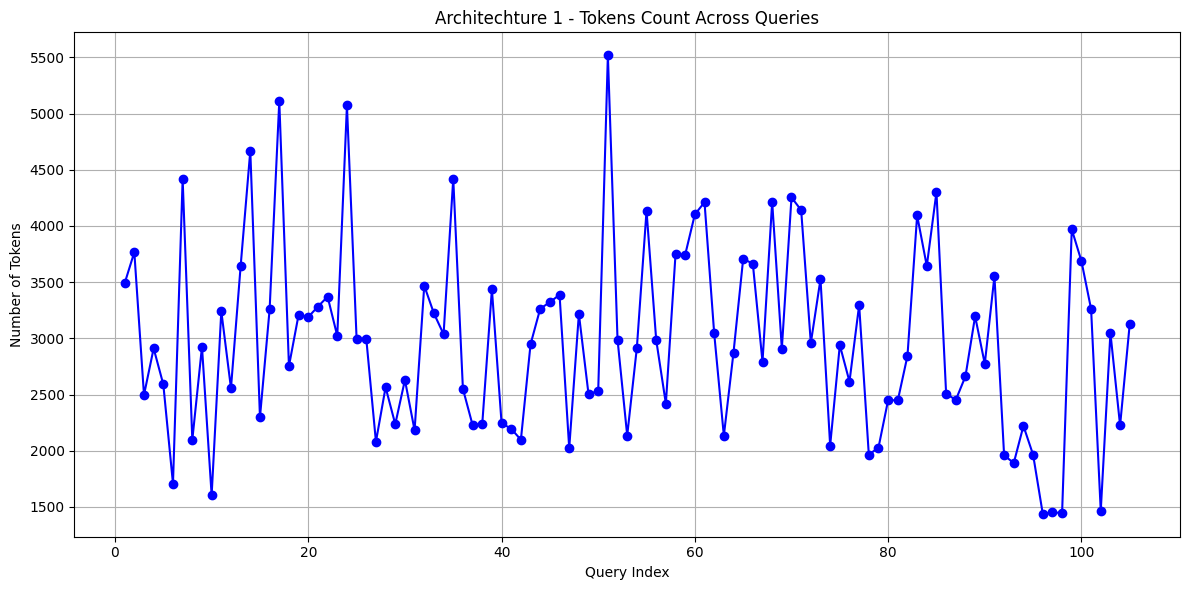

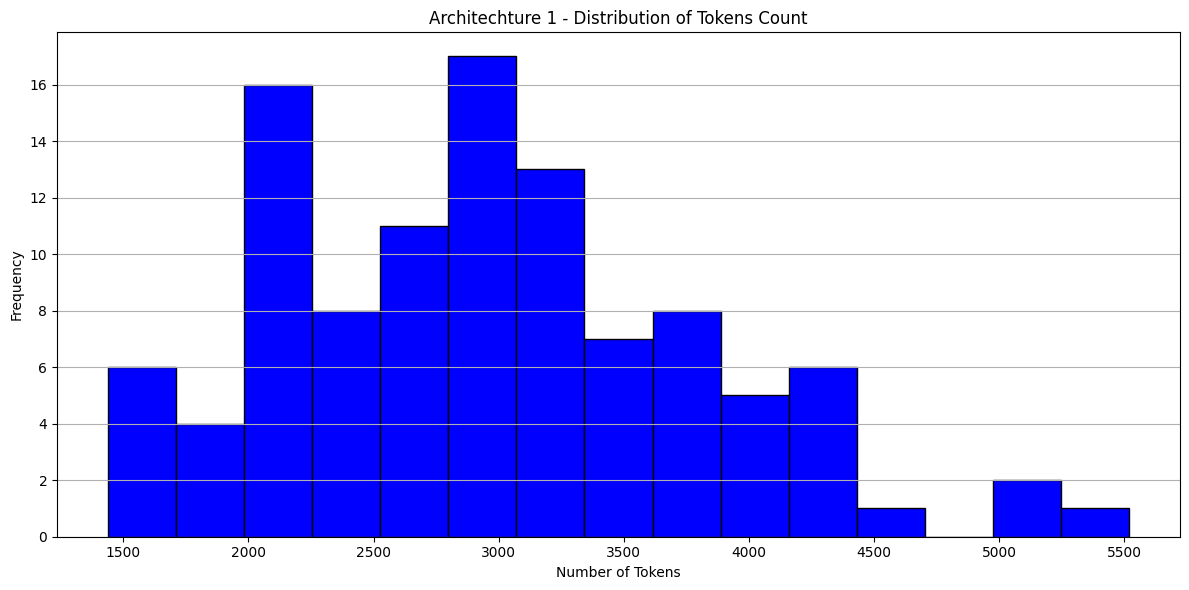

In [181]:
import matplotlib.pyplot as plt

# Your token counts data
token_counts = [
    3490, 3767, 2496, 2911, 2590, 1707, 4417, 2096, 2925, 1604, 3242, 2557,
    3642, 4669, 2297, 3258, 5110, 2753, 3211, 3190, 3283, 3371, 3022, 5073,
    2995, 2998, 2080, 2565, 2236, 2630, 2182, 3469, 3222, 3037, 4421, 2551,
    2229, 2236, 3436, 2246, 2195, 2098, 2948, 3264, 3322, 3388, 2023, 3217,
    2502, 2533, 5519, 2989, 2135, 2917, 4135, 2986, 2419, 3748, 3744, 4103,
    4211, 3045, 2134, 2874, 3708, 3664, 2791, 4214, 2909, 4254, 4141, 2958,
    3527, 2046, 2940, 2615, 3297, 1965, 2028, 2451, 2448, 2844, 4094, 3644,
    4302, 2508, 2452, 2662, 3197, 2773, 3554, 1959, 1891, 2221, 1964, 1439,
    1451, 1447, 3970, 3688, 3261, 1464, 3049, 2225, 3129
]

# Define x-axis values starting at 1
x_values = range(1, len(token_counts) + 1)

# Create a line plot of the token counts
plt.figure(figsize=(12, 6))
plt.plot(x_values, token_counts, marker='o', linestyle='-', color='b')
plt.title('Architechture 1 - Tokens Count Across Queries')
plt.xlabel('Query Index')
plt.ylabel('Number of Tokens')
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a histogram of the token counts
plt.figure(figsize=(12, 6))
plt.hist(token_counts, bins=15, color='blue', edgecolor='black')
plt.title('Architechture 1 - Distribution of Tokens Count')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


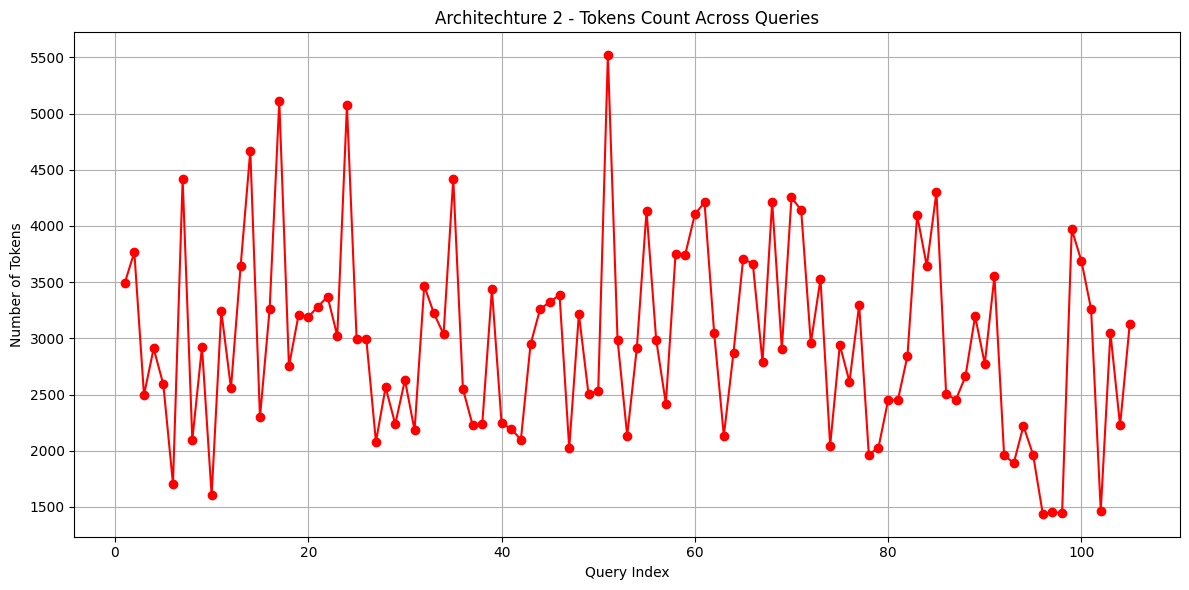

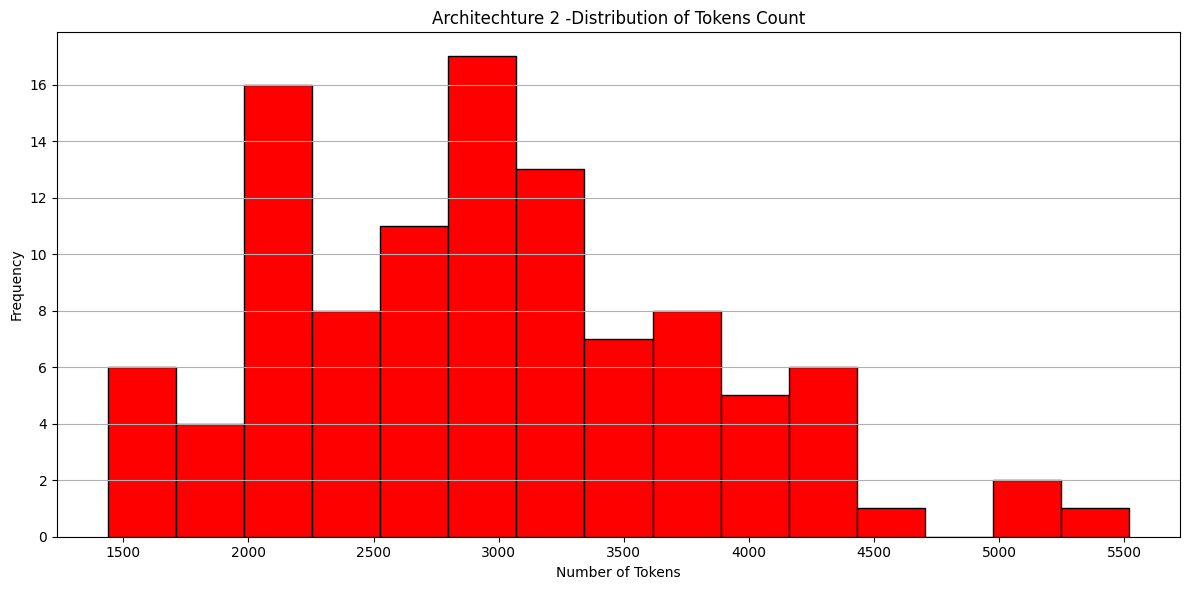

In [182]:
import matplotlib.pyplot as plt

# Your token counts data
tokens = [
  "1.639", "1.598", "1.624","1.613","1.666","1.690", "1.643","1.626","1.622",
  "1.607","1.735","1.874","1.731","1.735","1.775","1.739","1.712","1.670","1.768",
  "1.761","1.674","1.758","1.757","1.768","1.836","1.732","1.741","1.738","1.803",
  "1.738","1.753","1.802","1.885","1.820","1.766","1.781","1.868","1.879","1.737",
  "1.767","1.778","1.867","1.838","1.835","1.790","1.763","1.827","1.791","1.750",
  "1.846","1.816"," 1,814","1,906","1,906","1,833","1.908","1,839","1.866","1.762",
  "1.753","1.783","1.743","1.991","1.717","1.846","1.869","1.918","1.887","1.897",
  "1.971","1.839","1.842","1.875","1.928","1.859","1.914","1.852","1.901","1.836",
  "1.826","1.839","1.822","1.844","1.881","1.811","1.801","1.807","1.815","1.791",
  "1.921","1.814","1.683","1.787","1.856","1.847","1.866","1.850","1.777","1.804",
  "1.811","1.867","1.872","1.808","1.832","1.835","1.878"
  
  
  
]

# Define x-axis values starting at 1
x_values = range(1, len(token_counts) + 1)

# Create a line plot of the token counts
plt.figure(figsize=(12, 6))
plt.plot(x_values, token_counts, marker='o', linestyle='-', color='r')
plt.title('Architechture 2 - Tokens Count Across Queries')
plt.xlabel('Query Index')
plt.ylabel('Number of Tokens')
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a histogram of the token counts
plt.figure(figsize=(12, 6))
plt.hist(token_counts, bins=15, color='red', edgecolor='black')
plt.title('Architechture 2 -Distribution of Tokens Count')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


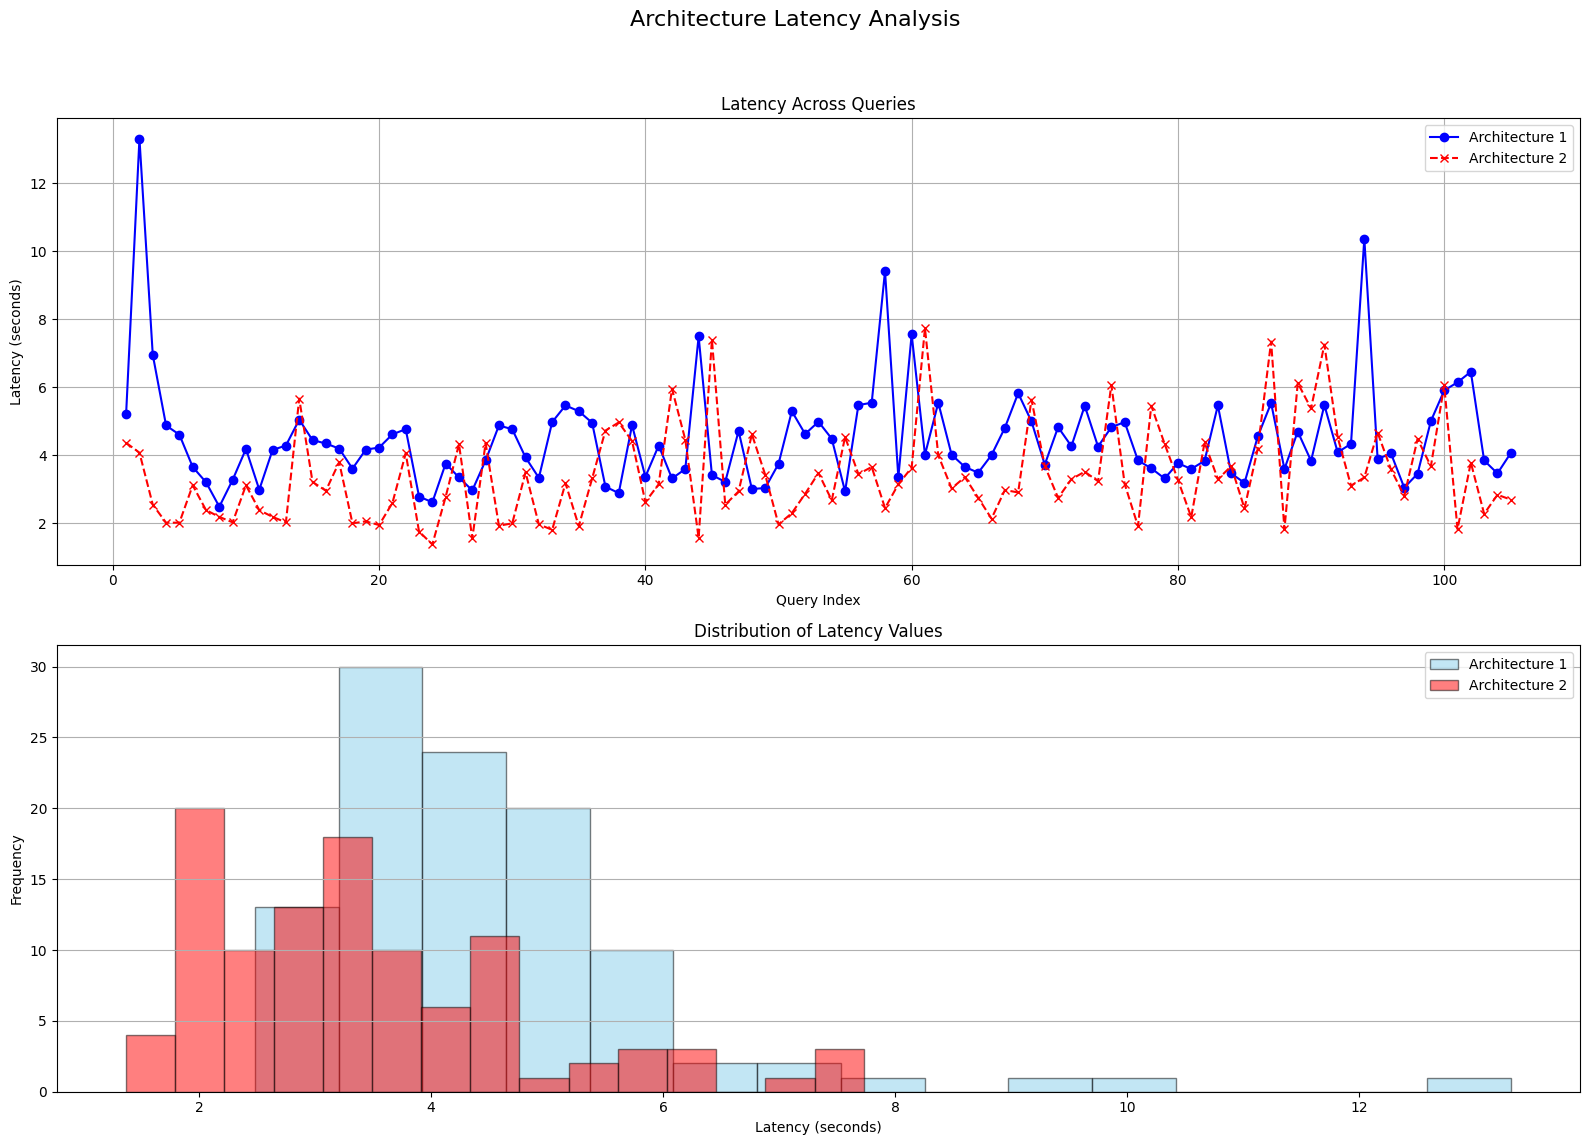

In [183]:
import matplotlib.pyplot as plt

# Define latency values for both architectures
token_counts_archi1 = [
    3490, 3767, 2496, 2911, 2590, 1707, 4417, 2096, 2925, 1604, 3242, 2557,
    3642, 4669, 2297, 3258, 5110, 2753, 3211, 3190, 3283, 3371, 3022, 5073,
    2995, 2998, 2080, 2565, 2236, 2630, 2182, 3469, 3222, 3037, 4421, 2551,
    2229, 2236, 3436, 2246, 2195, 2098, 2948, 3264, 3322, 3388, 2023, 3217,
    2502, 2533, 5519, 2989, 2135, 2917, 4135, 2986, 2419, 3748, 3744, 4103,
    4211, 3045, 2134, 2874, 3708, 3664, 2791, 4214, 2909, 4254, 4141, 2958,
    3527, 2046, 2940, 2615, 3297, 1965, 2028, 2451, 2448, 2844, 4094, 3644,
    4302, 2508, 2452, 2662, 3197, 2773, 3554, 1959, 1891, 2221, 1964, 1439,
    1451, 1447, 3970, 3688, 3261, 1464, 3049, 2225, 3129
]
token_counts_archi2 = [
  "1.639", "1.598", "1.624","1.613","1.666","1.690", "1.643","1.626","1.622",
  "1.607","1.735","1.874","1.731","1.735","1.775","1.739","1.712","1.670","1.768",
  "1.761","1.674","1.758","1.757","1.768","1.836","1.732","1.741","1.738","1.803",
  "1.738","1.753","1.802","1.885","1.820","1.766","1.781","1.868","1.879","1.737",
  "1.767","1.778","1.867","1.838","1.835","1.790","1.763","1.827","1.791","1.750",
  "1.846","1.816"," 1,814","1,906","1,906","1,833","1.908","1,839","1.866","1.762",
  "1.753","1.783","1.743","1.991","1.717","1.846","1.869","1.918","1.887","1.897",
  "1.971","1.839","1.842","1.875","1.928","1.859","1.914","1.852","1.901","1.836",
  "1.826","1.839","1.822","1.844","1.881","1.811","1.801","1.807","1.815","1.791",
  "1.921","1.814","1.683","1.787","1.856","1.847","1.866","1.850","1.777","1.804",
  "1.811","1.867","1.872","1.808","1.832","1.835","1.878"
  
  
  
]

   

# Convert latency values to floats
latency_floats_arch1 = [float(value.strip('s')) for value in latency_values_arch1]
latency_floats_arch2 = [float(value) for value in latency_values_arch2]

# Define x-axis values
x_values_arch1 = range(1, len(latency_floats_arch1) + 1)
x_values_arch2 = range(1, len(latency_floats_arch2) + 1)

# Create a combined plot with subplots
fig, axs = plt.subplots(2, 1, figsize=(16, 12))

# Line plot for Architecture 1 and Architecture 2
axs[0].plot(x_values_arch1, latency_floats_arch1, marker='o', linestyle='-', color='b', label='Architecture 1')
axs[0].plot(x_values_arch2, latency_floats_arch2, marker='x', linestyle='--', color='r', label='Architecture 2')
axs[0].set_title('Latency Across Queries')
axs[0].set_xlabel('Query Index')
axs[0].set_ylabel('Latency (seconds)')
axs[0].grid(True)
axs[0].legend()

# Histogram for Architecture 1 and Architecture 2
axs[1].hist(latency_floats_arch1, bins=15, color='skyblue', edgecolor='black', alpha=0.5, label='Architecture 1')
axs[1].hist(latency_floats_arch2, bins=15, color='red', edgecolor='black', alpha=0.5, label='Architecture 2')
axs[1].set_title('Distribution of Latency Values')
axs[1].set_xlabel('Latency (seconds)')
axs[1].set_ylabel('Frequency')
axs[1].grid(axis='y')
axs[1].legend()

# Add title and layout adjustment
fig.suptitle('Architecture Latency Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


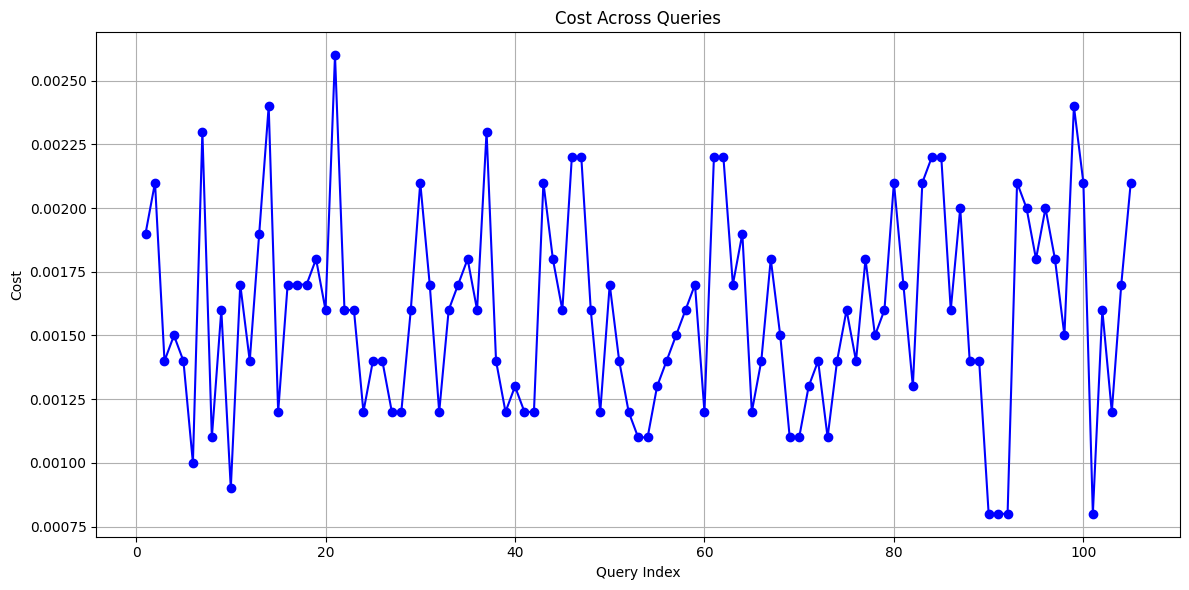

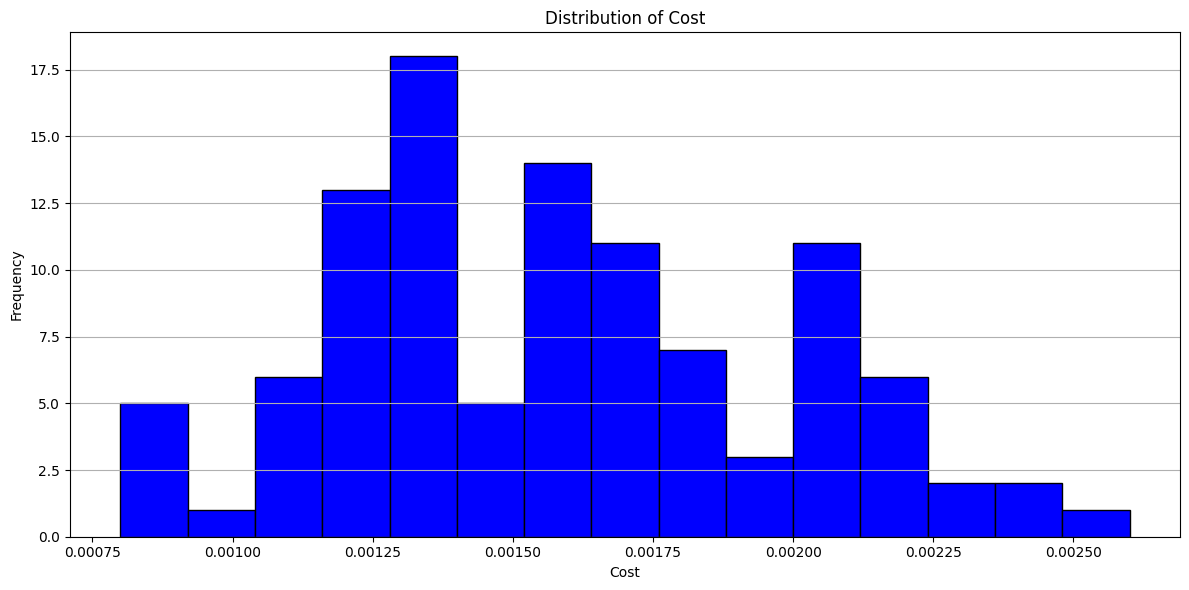

In [184]:
import matplotlib.pyplot as plt

# Your cost data
costs = [
    "$0.0019", "$0.0021", "$0.0014", "$0.0015", "$0.0014",
    "$0.0010", "$0.0023", "$0.0011", "$0.0016", "$0.0009",
    "$0.0017", "$0.0014", "$0.0019", "$0.0024", "$0.0012",
    "$0.0017", "$0.0017", "$0.0017", "$0.0018", "$0.0016",
    "$0.0026", "$0.0016", "$0.0016", "$0.0012", "$0.0014",
    "$0.0014", "$0.0012", "$0.0012", "$0.0016", "$0.0021",
    "$0.0017", "$0.0012", "$0.0016", "$0.0017", "$0.0018",
    "$0.0016", "$0.0023", "$0.0014", "$0.0012", "$0.0013",
    "$0.0012", "$0.0012", "$0.0021", "$0.0018", "$0.0016",
    "$0.0022", "$0.0022", "$0.0016", "$0.0012", "$0.0017",
    "$0.0014", "$0.0012", "$0.0011", "$0.0011", "$0.0013",
    "$0.0014", "$0.0015", "$0.0016", "$0.0017", "$0.0012",
    "$0.0022", "$0.0022", "$0.0017", "$0.0019", "$0.0012",
    "$0.0014", "$0.0018", "$0.0015", "$0.0011", "$0.0011",
    "$0.0013", "$0.0014", "$0.0011", "$0.0014", "$0.0016",
    "$0.0014", "$0.0018", "$0.0015", "$0.0016", "$0.0021",
    "$0.0017", "$0.0013", "$0.0021", "$0.0022", "$0.0022",
    "$0.0016", "$0.0020", "$0.0014", "$0.0014", "$0.0008",
    "$0.0008", "$0.0008", "$0.0021", "$0.0020", "$0.0018",
    "$0.0020", "$0.0018", "$0.0015", "$0.0024", "$0.0021",
    "$0.0008", "$0.0016", "$0.0012", "$0.0017", "$0.0021"
]

# Convert costs from strings to floats
costs = [float(cost.strip('$')) for cost in costs]

# Define x-axis values starting at 1
x_values = range(1, len(costs) + 1)

# Create a line plot of the costs
plt.figure(figsize=(12, 6))
plt.plot(x_values, costs, marker='o', linestyle='-', color='b')
plt.title('Cost Across Queries')
plt.xlabel('Query Index')
plt.ylabel('Cost')
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a histogram of the costs
plt.figure(figsize=(12, 6))
plt.hist(costs, bins=15, color='blue', edgecolor='black')
plt.title('Distribution of Cost')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


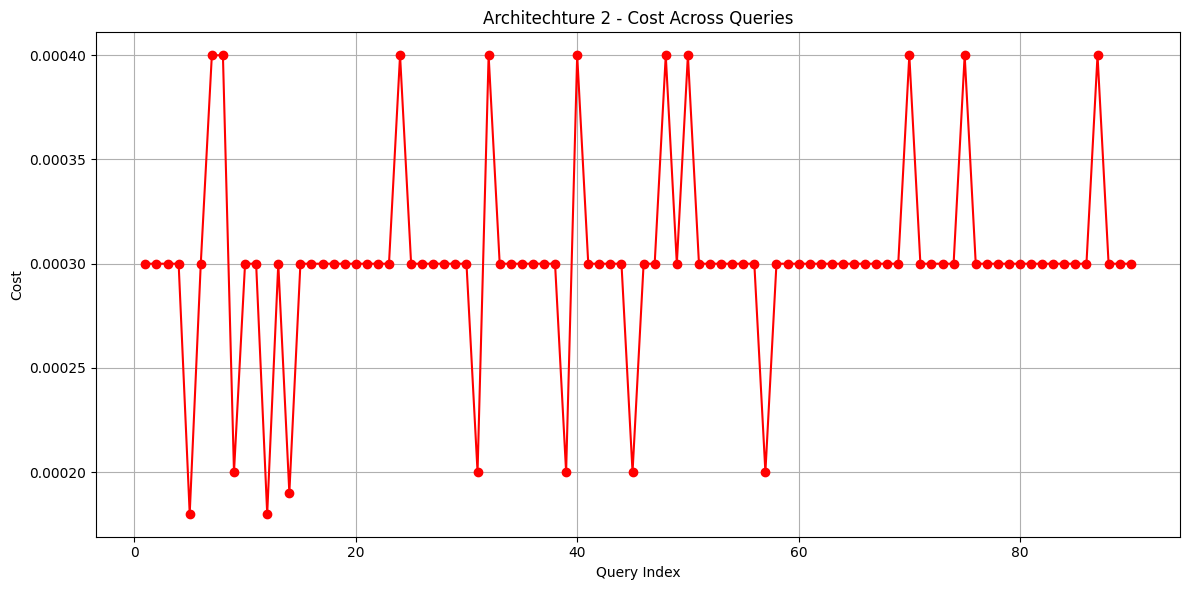

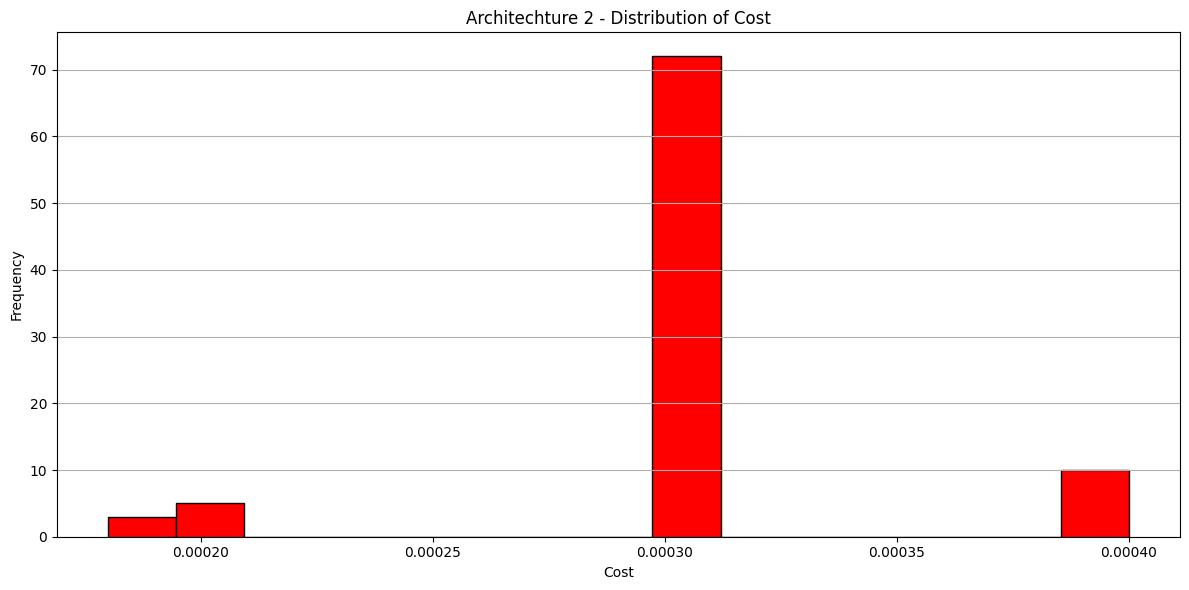

In [188]:
import matplotlib.pyplot as plt

# Your cost data


costs = [
    "$0.0003", "$0.0003", "$0.0003", "$0.0003", "$0.00018", "$0.0003", "$0.0004",
    "$0.0004", "$0.0002", "$0.0003", "$0.0003", "$0.00018", "$0.0003", "$0.00019",
    "$0.0003", "$0.0003", "$0.0003", "$0.0003", "$0.0003", "$0.0003", "$0.0003",
    "$0.0003", "$0.0003", "$0.0004", "$0.0003", "$0.0003", "$0.0003", "$0.0003",
    "$0.0003", "$0.0003", "$0.0002", "$0.0004", "$0.0003", "$0.0003", "$0.0003",
    "$0.0003", "$0.0003", "$0.0003", "$0.0002", "$0.0004", "$0.0003", "$0.0003",
    "$0.0003", "$0.0003", "$0.0002", "$0.0003", "$0.0003", "$0.0004", "$0.0003",
    "$0.0004", "$0.0003", "$0.0003", "$0.0003", "$0.0003", "$0.0003", "$0.0003",
    "$0.0002", "$0.0003", "$0.0003", "$0.0003", "$0.0003", "$0.0003", "$0.0003",
    "$0.0003", "$0.0003", "$0.0003", "$0.0003", "$0.0003", "$0.0003", "$0.0004",
    "$0.0003", "$0.0003", "$0.0003", "$0.0003", "$0.0004", "$0.0003", "$0.0003",
    "$0.0003", "$0.0003", "$0.0003", "$0.0003", "$0.0003", "$0.0003", "$0.0003",
    "$0.0003", "$0.0003", "$0.0004", "$0.0003", "$0.0003", "$0.0003"
]

# Convert costs from strings to floats
costs = [float(cost.strip('$')) for cost in costs]

# Define x-axis values starting at 1
x_values = range(1, len(costs) + 1)

# Create a line plot of the costs
plt.figure(figsize=(12, 6))
plt.plot(x_values, costs, marker='o', linestyle='-', color='r')
plt.title('Architechture 2 - Cost Across Queries')
plt.xlabel('Query Index')
plt.ylabel('Cost')
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a histogram of the costs
plt.figure(figsize=(12, 6))
plt.hist(costs, bins=15, color='red', edgecolor='black')
plt.title('Architechture 2 - Distribution of Cost')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


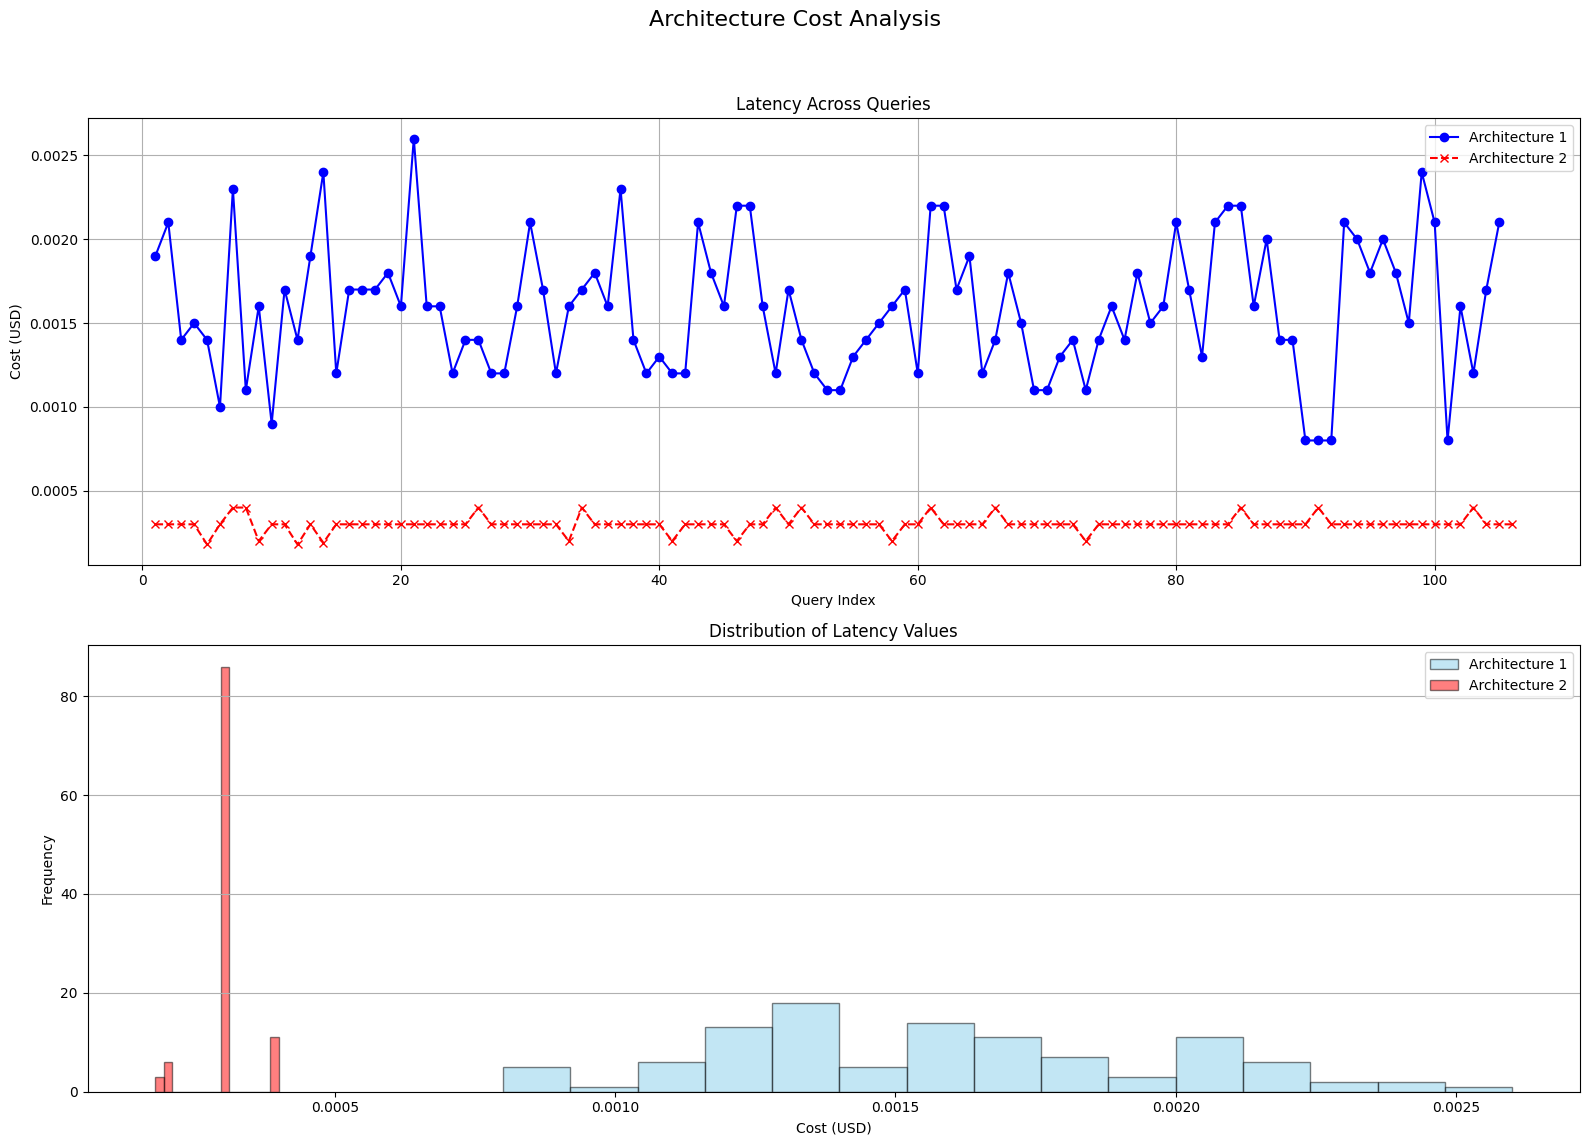

In [190]:
import matplotlib.pyplot as plt

# Define latency values for both architectures
costss = [
    "$0.0019", "$0.0021", "$0.0014", "$0.0015", "$0.0014",
    "$0.0010", "$0.0023", "$0.0011", "$0.0016", "$0.0009",
    "$0.0017", "$0.0014", "$0.0019", "$0.0024", "$0.0012",
    "$0.0017", "$0.0017", "$0.0017", "$0.0018", "$0.0016",
    "$0.0026", "$0.0016", "$0.0016", "$0.0012", "$0.0014",
    "$0.0014", "$0.0012", "$0.0012", "$0.0016", "$0.0021",
    "$0.0017", "$0.0012", "$0.0016", "$0.0017", "$0.0018",
    "$0.0016", "$0.0023", "$0.0014", "$0.0012", "$0.0013",
    "$0.0012", "$0.0012", "$0.0021", "$0.0018", "$0.0016",
    "$0.0022", "$0.0022", "$0.0016", "$0.0012", "$0.0017",
    "$0.0014", "$0.0012", "$0.0011", "$0.0011", "$0.0013",
    "$0.0014", "$0.0015", "$0.0016", "$0.0017", "$0.0012",
    "$0.0022", "$0.0022", "$0.0017", "$0.0019", "$0.0012",
    "$0.0014", "$0.0018", "$0.0015", "$0.0011", "$0.0011",
    "$0.0013", "$0.0014", "$0.0011", "$0.0014", "$0.0016",
    "$0.0014", "$0.0018", "$0.0015", "$0.0016", "$0.0021",
    "$0.0017", "$0.0013", "$0.0021", "$0.0022", "$0.0022",
    "$0.0016", "$0.0020", "$0.0014", "$0.0014", "$0.0008",
    "$0.0008", "$0.0008", "$0.0021", "$0.0020", "$0.0018",
    "$0.0020", "$0.0018", "$0.0015", "$0.0024", "$0.0021",
    "$0.0008", "$0.0016", "$0.0012", "$0.0017", "$0.0021"
]
costs = [
    "0.0003", "0.0003", "0.0003", "0.0003", "0.00018", "0.0003", "0.0004",
    "0.0004", "0.0002", "0.0003", "0.0003", "0.00018", "0.0003", "0.00019", "0.0003", "0.0003",
    "0.0003", "0.0003", "0.0003", "0.0003", "0.0003", "0.0003", "0.0003", "0.0003", "0.0003", "0.0004",
    "0.0003", "0.0003", "0.0003", "0.0003", "0.0003", "0.0003", "0.0002", "0.0004", "0.0003", "0.0003",
    "0.0003", "0.0003", "0.0003", "0.0003", "0.0002", "0.0003", "0.0003", "0.0003", "0.0003", "0.0002",
    "0.0003", "0.0003", "0.0004", "0.0003", "0.0004", "0.0003", "0.0003", "0.0003", "0.0003", "0.0003",
    "0.0003", "0.0002", "0.0003", "0.0003", "0.0004", "0.0003", "0.0003", "0.0003", "0.0003", "0.0004",
    "0.0003", "0.0003", "0.0003", "0.0003", "0.0003", "0.0003", "0.0002", "0.0003", "0.0003", "0.0003",
    "0.0003", "0.0003", "0.0003", "0.0003", "0.0003", "0.0003", "0.0003", "0.0003", "0.0004", "0.0003",
    "0.0003", "0.0003", "0.0003", "0.0003", "0.0004", "0.0003", "0.0003", "0.0003", "0.0003", "0.0003",
    "0.0003", "0.0003", "0.0003", "0.0003", "0.0003", "0.0003", "0.0004", "0.0003", "0.0003", "0.0003"
]

# Convert cost values to floats
costs_floats_arch1 = [float(value.strip('$')) for value in costss]
costs_floats_arch2 = [float(value) for value in costs]

# Define x-axis values
x_values_arch1 = range(1, len(costs_floats_arch1) + 1)
x_values_arch2 = range(1, len(costs_floats_arch2) + 1)

# Create a combined plot with subplots
fig, axs = plt.subplots(2, 1, figsize=(16, 12))

# Line plot for Architecture 1 and Architecture 2
axs[0].plot(x_values_arch1, costs_floats_arch1, marker='o', linestyle='-', color='b', label='Architecture 1')
axs[0].plot(x_values_arch2, costs_floats_arch2, marker='x', linestyle='--', color='r', label='Architecture 2')
axs[0].set_title('Latency Across Queries')
axs[0].set_xlabel('Query Index')
axs[0].set_ylabel('Cost (USD)')
axs[0].grid(True)
axs[0].legend()

# Histogram for Architecture 1 and Architecture 2
axs[1].hist(costs_floats_arch1, bins=15, color='skyblue', edgecolor='black', alpha=0.5, label='Architecture 1')
axs[1].hist(costs_floats_arch2, bins=15, color='red', edgecolor='black', alpha=0.5, label='Architecture 2')
axs[1].set_title('Distribution of Latency Values')
axs[1].set_xlabel('Cost (USD)')
axs[1].set_ylabel('Frequency')
axs[1].grid(axis='y')
axs[1].legend()

# Add title and layout adjustment
fig.suptitle('Architecture Cost Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()
